Here we defined our own exposure estimation modell. Based on the input picture it predicts an amplification ratio.

Hyperparameters which can easily be changed.

In [2]:
HEIGHT = 64
WIDTH = 64

Here are all the imports.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Embedding
from tensorflow.keras.optimizers import SGD

import os
import skimage.io as io
import skimage.transform as trasns

from keras.models import *
from keras.layers import *
from keras.losses import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, Callback, ReduceLROnPlateau

import rawpy
import cv2
import numpy as np
from numpy import genfromtxt

import time
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from PIL import Image
import pandas
from sklearn.preprocessing import StandardScaler

The paths to the directories

In [4]:
trainPath = "/home/takats_balint1/deephf/data/Sony_train_list.txt"
valPath = "/home/takats_balint1/deephf/data/Sony_val_list.txt"
testPath = "/home/takats_balint1/deephf/data/Sony_test_list.txt"
replaceString = "/home/takats_balint1/deephf/data"

This function returns tuple, consisting of the raw, and its ground truth pair paths'

In [5]:
def LoadData(path):
    Data = []
    with open(path) as File:
        for line in File:
            data, truth, _, _ = line.split()
            data = data.replace(".", replaceString, 1)
            truth = truth.replace(".", replaceString, 1)
            # This method is slow but we only have a 1000 lines so this quick and dirty algortihm will do just fine
            Data.append([data, truth])
    print (len(Data))
    return Data

load in the train, validation and test dataset

In [6]:
trainData = LoadData(trainPath)

1865


In [7]:
valData = LoadData(valPath)

234


In [8]:
testData = LoadData(testPath)

598


fixfile returns the resized, smaller version of the given file, for this, a different script previously resized and created a library for the smaller images

In [9]:
def fixFile(file):
    return file.replace("data", "smalldata").replace("ARW", "csv")

loadFile, using fixfile and genfromtxt, returns an ndarray, with the given shape

In [10]:
def loadFile(file):
    good = fixFile(file)
    data = genfromtxt(good, delimiter=',')
    return data.reshape((HEIGHT, WIDTH,3))

Ratio function with the appropiate exposure ratio. We use this as the groud truth.

In [11]:
def Ratio(in_path, truth_path):
    in_exposure = float(in_path[53:-5])
    gt_exposure = float(truth_path[52:-5])
    ratio = min(gt_exposure / in_exposure, 300)
    return ratio

train_Data and val_Data both returns two-two ndarrays, consisting of the raw images loaded in using loadfile, and the amplification ratio, which stands as the ground truth for this network

In [12]:
def train_Data():
    trainPermutation = np.random.permutation(len(trainData))
    data = [None] * len(trainData)
    truth = [None] * len(trainData)
    
    start_time = time.time()
    
    for i in range(0, len(trainPermutation)):
        ratio = Ratio(trainData[trainPermutation[i]][0], trainData[trainPermutation[i]][1])
        truth[i] = ratio
        raw = loadFile(trainData[trainPermutation[i]][0])
        data[i] = raw
        
    load_end_time = time.time()
    
    print("Train data load time taken: " + str(load_end_time-start_time))
    
    return np.array(data), np.array(truth)

In [13]:
def val_Data():
    valPermutation = np.random.permutation(len(valData))
    val_data = [None] * len(valData)
    val_truth = [None] * len(valData)
    
    start_time = time.time()
    
    for i in range(0, len(valPermutation)):
        ratio = Ratio(valData[valPermutation[i]][0], valData[valPermutation[i]][1])
        val_truth[i] = ratio
        raw = loadFile(valData[valPermutation[i]][0])
        val_data[i] = raw
        
    load_end_time = time.time()
    
    print("Validation data load time taken: " + str(load_end_time-start_time))
    
    return np.array(val_data), np.array(val_truth)

Loading in from memory takes a bit of time, but thats acceptable, since roughly 2000 images and their ground truth pair are being loaded in

In [13]:
data, truth = train_Data()
val_data, val_truth = val_Data()

Train data load time taken: 409.1029164791107
Validation data load time taken: 47.7675096988678


Scaling the truth value, by this, we're allowing the network to more quickly learn the optimal parameters for each input 

In [14]:
truth = truth.reshape(-1, 1)
val_truth = val_truth.reshape(-1, 1)

scaler = StandardScaler()
truth = scaler.fit_transform(truth)
val_truth = scaler.fit_transform(val_truth)

Loading best hyperparameters from a log file which we created in the HyperOptScript

In [23]:
hyperas_log = pandas.read_csv('hyperas-NHF-log.csv', delimiter=';')
best_hyperps = hyperas_log.sort_values(by=['best_val_loss'], ascending=True).head(n=1)
best_hyperps

,n_layer1,n_layer2,n_layer3,dropout_1,dropout_2,k_size1,k_size2,act,optim,n_batch,lr,stride_1,stride_2,stride_3,best_val_loss
199,8,4,32,0.406023,0.185245,5,3,relu,adam,2,0.001,2,2,2,0.348148


In [24]:
best_hyperps = best_hyperps.to_numpy()
n_layer1, n_layer2, n_layer3, dropout_1, dropout_2, k_size1, k_size2, act, optim, n_batch, lr, stride_1, stride_2, stride_3, best_val_loss = best_hyperps.reshape(1, -1).T

Set activation and optimizer

In [85]:
activat = ReLU()
if act == 'leakyrelu':
    activat = LeakyReLU()
elif act == 'elu':
    activat = ELU()
    
if optim == 'rmsprop':
    optimiz = RMSprop(learning_rate=lr.item())
elif optim == 'sgd':
    optimiz = SGD(learning_rate=lr.item())
elif optim == 'adam':
    optimiz = Adam(learning_rate=lr.item())

For the model, we use a cnn with 3 conv. layers,dropout, and a flatten layer before the last dense with 1 output

In [100]:
model = Sequential() 
model.add(Conv2D(n_layer1.item(), kernel_size=(k_size1.item(), k_size1.item()), activation=activat, input_shape=(HEIGHT, WIDTH, 3), strides= stride_1.item())) 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_1.item()))
model.add(Conv2D(n_layer2.item(), (k_size2.item(), k_size2.item()), activation=activat, strides = stride_2.item())) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(dropout_2.item()))
model.add(Conv2D(n_layer3.item(), (3, 3), activation=activat, strides = stride_3.item()))
model.add(Flatten())
model.add(Dense(1))
    
model.compile(loss='mse', optimizer=optimiz)   
model.summary()

Model = model

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 30, 30, 8)         608       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 15, 15, 8)         0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 15, 15, 8)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 7, 7, 4)           292       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 3, 3, 4)           0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 3, 3, 4)           0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 1, 1, 32)        

In [101]:
class TrainingHistory(Callback):
    # Empty lists
    def on_train_begin(self, logs={}):
        # Loss in training data
        self.losses = []
        # Loss in validation data
        self.valid_losses = []
        # Epoch number
        self.epoch = 0
    
    # Saving network state
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
        self.epoch += 1
            
history = TrainingHistory()

We used early stopping, to reduce the chances of overfitting, or to help reducing validation loss, using lronplateau

In [102]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=8, min_lr=10e-5)

callbacks = [early_stopping, history, reduce_lr]

Training the model: after reading the raw image in we resize it to match the input_size of the network.
Truth will be the reference/output for the network which we supposed to get after a succesful training

In [103]:
result = Model.fit(data, truth, batch_size=n_batch.item(), validation_data=(val_data, val_truth), epochs = 100, callbacks=callbacks)
Model.save('exposure_model')

Epoch 1/100
933/933 [==============================] - 4s 4ms/step - loss: 0.8903 - val_loss: 0.9363
Epoch 2/100
933/933 [==============================] - 4s 4ms/step - loss: 0.7383 - val_loss: 0.8149
Epoch 3/100
933/933 [==============================] - 4s 4ms/step - loss: 0.6325 - val_loss: 0.7542
Epoch 4/100
933/933 [==============================] - 4s 4ms/step - loss: 0.5857 - val_loss: 0.6760
Epoch 5/100
933/933 [==============================] - 4s 4ms/step - loss: 0.5563 - val_loss: 0.7164
Epoch 6/100
933/933 [==============================] - 4s 4ms/step - loss: 0.5233 - val_loss: 0.5789
Epoch 7/100
933/933 [==============================] - 4s 4ms/step - loss: 0.5219 - val_loss: 0.5933
Epoch 8/100
933/933 [==============================] - 4s 4ms/step - loss: 0.5002 - val_loss: 0.5102
Epoch 9/100
933/933 [==============================] - 4s 4ms/step - loss: 0.4788 - val_loss: 0.4856
Epoch 10/100
933/933 [==============================] - 4s 4ms/step - loss: 0.4609 - val_lo

Reading in the test data, just as done with training and validation data

In [14]:
def test_Data():
    testPermutation = np.random.permutation(len(testData))
    test_data = [None] * len(testData)
    test_truth = [None] * len(testData)
    
    start_time = time.time()
    
    for i in range(0, len(testPermutation)):
        ratio = Ratio(testData[testPermutation[i]][0], testData[testPermutation[i]][1])
        test_truth[i] = ratio
        raw = loadFile(testData[testPermutation[i]][0])
        test_data[i] = raw
        
    load_end_time = time.time()
    
    print("Test data load time taken: " + str(load_end_time-start_time))
    
    return np.array(test_data), np.array(test_truth)

In [15]:
test_data, test_truth = test_Data()

Test data load time taken: 120.65511107444763


Predicting with the test_data, then inverse-scaling the prediction to match the original test_truth

In [104]:
preds = Model.predict(test_data)

Printing the stops between the predited and actual exposure value
Stop is a measurement of Exposure.
For example, if you were to increase the exposure by one stop – you would in effect be doubling the exposure.
An amateur photographer can easily be one stop inaccurate. 

In [105]:
preds = scaler.inverse_transform(preds)
for i in range(len(preds[:20])):
    print(abs(math.log(preds[i], 2.0) - math.log(test_truth[i], 2.0)))

0.12719095532913904
1.424899951279535
0.12593356063627503
0.00035347452566725224
0.14031821978070091
0.161796680283393
0.0931873646283119
0.1506322607244659
0.14031821978070091
0.586025056767209
1.3760337931450017
0.159269037223277
0.24731464243670498
0.21435903336664275
0.37450013838176943
0.14031821978070091
0.4740017564508392
0.4471910341226595
0.20749352192138204
0.12271618605309342


Displaying the first 50 predicted and the actual exposue values

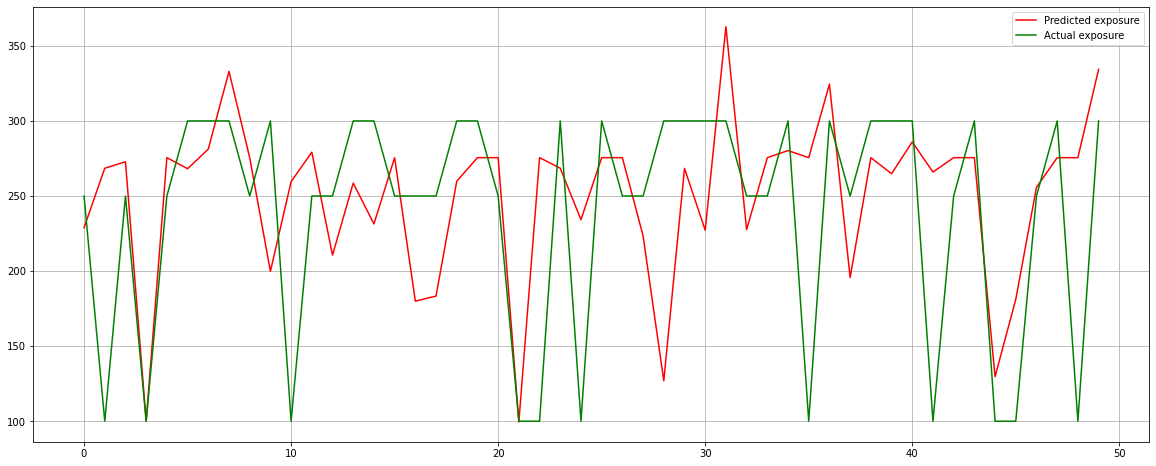

In [106]:
plt.figure(figsize=(20, 8))
plt.plot(preds[:50], color ='r', label='Predicted exposure') 
plt.plot(test_truth[:50], color ='g', label='Actual exposure')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

As visible, the predictions were pretty close to the truth, approximately 0.5 stop is the maximum difference.
We suppose the small difference is due to resizing the images, and thus losing information

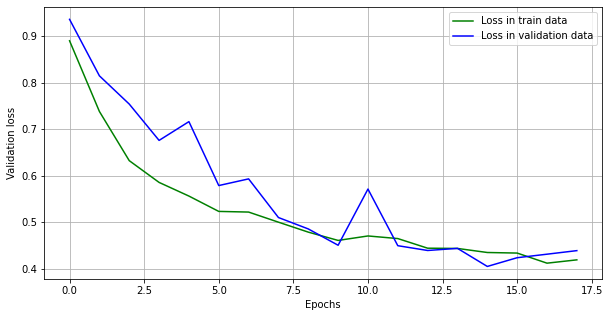

In [107]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(history.epoch), history.losses, color ='g', label='Loss in train data') 
plt.plot(np.arange(history.epoch), history.valid_losses, color ='b', label='Loss in validation data')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.grid(True)
plt.show()

Plotting the change of the losses